## Load Packages

In [140]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import os
import shutil
import random
import collections
import tifffile as tiff
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 1
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU enabled for TensorFlow!


## Analyse Bands(Channels)

In [ ]:
import rasterio
file_path = "/kaggle/input/water-segmentation/data/images/10.tif"
with rasterio.open(file_path) as src:
    print(f"Total Bands: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)  # Read band as a NumPy array
        print(f"Band {i}: Shape {band.shape}, Min {band.min()}, Max {band.max()}")


Total Bands: 12
Band 1: Shape (128, 128), Min -83, Max 773
Band 2: Shape (128, 128), Min -103, Max 830
Band 3: Shape (128, 128), Min -14, Max 1109
Band 4: Shape (128, 128), Min -10, Max 1827
Band 5: Shape (128, 128), Min -131, Max 4152
Band 6: Shape (128, 128), Min -92, Max 3638
Band 7: Shape (128, 128), Min -29, Max 2673
Band 8: Shape (128, 128), Min 64, Max 224
Band 9: Shape (128, 128), Min 176, Max 187
Band 10: Shape (128, 128), Min 157, Max 180
Band 11: Shape (128, 128), Min 10, Max 90
Band 12: Shape (128, 128), Min 0, Max 94


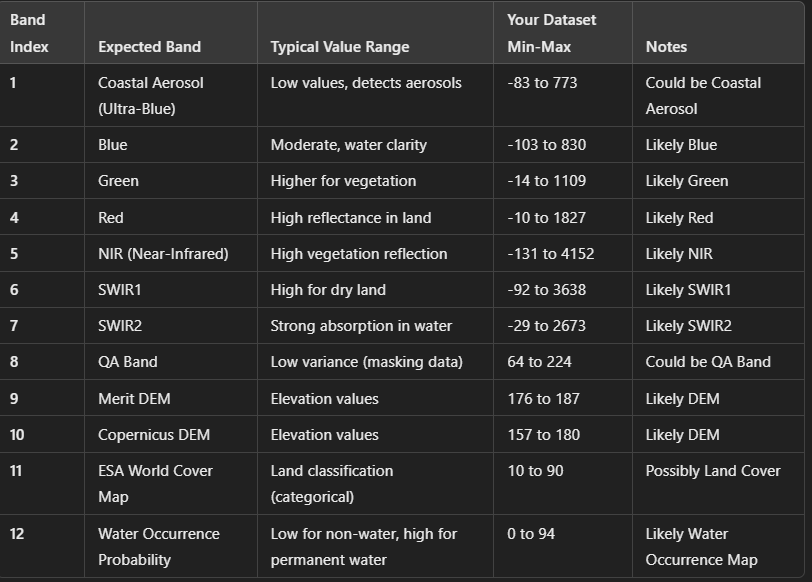

In [ ]:
# import os
# import rasterio
# import numpy as np

# # Directory containing images
# image_dir = "/kaggle/input/water-segmentation/data/images"

# # List TIFF files in the directory
# tif_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]

# if not tif_files:
#     raise FileNotFoundError("No TIFF files found in the directory.")

# # Select the first TIFF file
# tif_path = os.path.join(image_dir, tif_files[0])
# print("Using file:", tif_path)

# # Bands to extract (1-based indexing)
# selected_bands = [3, 5, 6, 7, 12, 9]  # Green, NIR, SWIR1, SWIR2, Water Occurrence, DEM

# # Open the selected TIFF file
# with rasterio.open(tif_path) as dataset:
#     selected_data = np.stack([dataset.read(b) for b in selected_bands], axis=0)

# # Check the shape
# print("Extracted Data Shape:", selected_data.shape)


Using file: /kaggle/input/water-segmentation/data/images/274.tif
Extracted Data Shape: (6, 128, 128)


## Load Data

In [ ]:
# Set the paths
image_dir = "/kaggle/input/water-segmentation/data/images"
label_dir = "/kaggle/input/water-segmentation/data/labels"
# List all images and labels
image_files=sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files=sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])
# Print some sample filenames
print("Sample Image Files:", image_files[:5])
print("Sample Label Files:", label_files[:5])
# Check mismatches
extra_labels=set(label_files)-set(image_files)
missing_labels=set(image_files)-set(label_files)
print("Extra Labels:", extra_labels)
print("Missing Labels:", missing_labels)


Sample Image Files: ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif']
Sample Label Files: ['0.png', '1.png', '10.png', '100.png', '100_184.png']
Extra Labels: {'299.png', '130.png', '10_244.png', '166.png', '180.png', '25_172.png', '101_89.png', '126_110.png', '103_225.png', '295.png', '109.png', '178.png', '146.png', '154.png', '51_91.png', '170.png', '52_160.png', '143_183.png', '168.png', '34.png', '100.png', '110_287.png', '292.png', '127_54.png', '1.png', '83.png', '50.png', '234.png', '205.png', '276.png', '197.png', '261.png', '252.png', '93.png', '75.png', '119_222.png', '206.png', '273.png', '91_102.png', '270.png', '115_49.png', '11_116.png', '278.png', '62_187.png', '151.png', '210.png', '196.png', '88_157.png', '82_100.png', '118_125.png', '301.png', '19.png', '142.png', '94_119.png', '240.png', '41.png', '185.png', '70.png', '136.png', '279.png', '26_274.png', '294.png', '232.png', '52.png', '31.png', '159.png', '129_177.png', '63_17.png', '38_68.png', '5_275.png', '177.p

### Train Valid Split

In [ ]:
# List all images and labels
image_files=sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files=sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])
# Remove extensions to compare file names
image_names={os.path.splitext(f)[0] for f in image_files}
label_names={os.path.splitext(f)[0] for f in label_files}
# Find matching image-label pairs
valid_names = image_names & label_names  # Intersection of filenames
# Create a list of tuples (image_path, label_path)
data = [(os.path.join(image_dir, f"{name}.tif"), os.path.join(label_dir, f"{name}.png")) for name in valid_names]
# Shuffle data
random.shuffle(data)
# Split into 70% train and 30% validation
train_data, val_data=train_test_split(data, test_size=0.3, random_state=42)
# Separate images and labels
train_images,train_labels=zip(*train_data) if train_data else ([], [])
val_images,val_labels=zip(*val_data) if val_data else ([], [])
# Convert to TensorFlow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
valid_dataset=tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))
# Check image shape
image_path="/kaggle/input/water-segmentation/data/images/101.tif"
image=tiff.imread(image_path)
print("Image shape:", image.shape)


Image shape: (128, 128, 12)


## Data Visualization

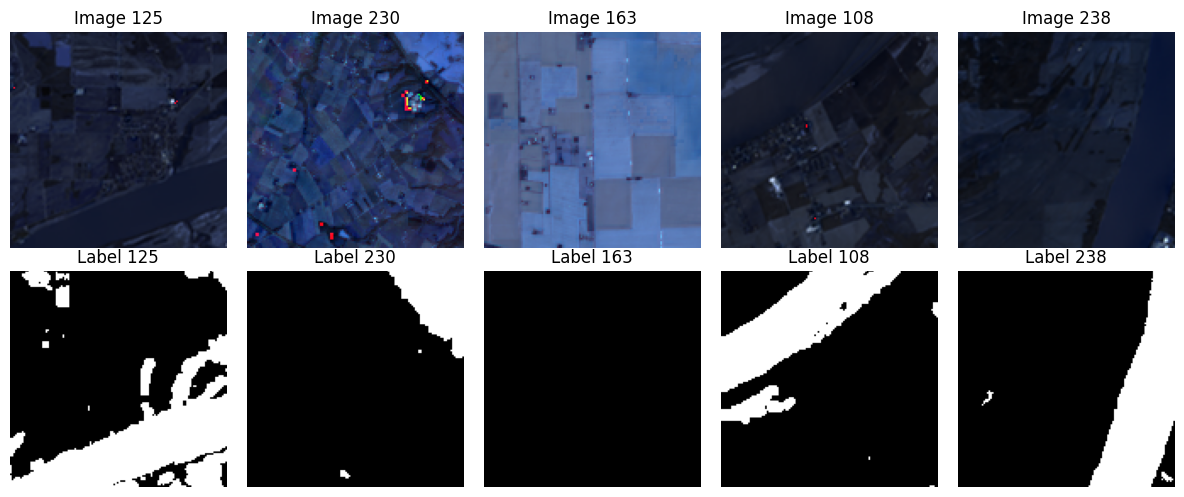

In [145]:
# Ensure matching images and labels (based on filename without extension)
image_files_dict = {os.path.splitext(f)[0]: f for f in image_files}
label_files_dict = {os.path.splitext(f)[0]: f for f in label_files}

# Find common files (ensuring correct matches)
common_keys = sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))

# Select 5 random samples from matching files
num_samples = min(5, len(common_keys))  # Avoid errors if less than 5 pairs exist
selected_keys = random.sample(common_keys, num_samples)

# Set figure size
fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])

    # Load multispectral image (12 channels)
    image = tiff.imread(image_path)

    # Convert to RGB using the first 3 channels
    image_rgb = image[:, :, :3]

    # Normalize to 8-bit (0-255)
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)

    # Load label image in grayscale
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Resize images for better visualization
    target_size = (128, 128)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)

    # Display the image
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")

    # Display the label
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Label {key}")
    axes[1, i].axis("off")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing

In [ ]:
# SELECTED BANDS (Green, NIR, SWIR1, SWIR2, Water Occurrence, DEM)
SELECTED_BANDS = [3, 5, 6, 7, 8, 11] # 1-based indexing in rasterio
def load_and_preprocess(image_path, label_path):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')
    # Read multispectral image using rasterio
    with rasterio.open(image_path) as src:
        image = np.stack([src.read(b) for b in SELECTED_BANDS], axis=-1)  # Shape: (H, W, 6)
    # Resize image (each band separately to avoid distortion)
    resized_bands = [cv2.resize(image[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC) for i in range(image.shape[-1])]
    image = np.stack(resized_bands, axis=-1)  # Shape: (128, 128, 6)
    # Normalize image (adjust based on data characteristics)
    image = image.astype(np.float32) / 10000.0  # Scaling factor for satellite data
    # Read label (grayscale mask)
    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    if label is None:
        raise ValueError(f"Error loading label: {label_path}")
    # Resize label
    label = cv2.resize(label, (128, 128), interpolation=cv2.INTER_NEAREST)
    # Normalize label (assuming binary mask 0-255)
    label = label.astype(np.float32) / 255.0
    # Ensure label has correct shape (128, 128, 1)
    if len(label.shape) == 2:
        label = np.expand_dims(label, axis=-1)
    return image, label
# --- WRAPPER FOR TENSORFLOW DATASET ---
def load_and_preprocess_wrapper(image_path, label_path):
    image, label = tf.py_function(
        func=load_and_preprocess, 
        inp=[image_path, label_path], 
        Tout=[tf.float32, tf.float32]
    )
    # Set known shapes
    image.set_shape((128, 128, len(SELECTED_BANDS)))  # Now (128, 128, 6)
    label.set_shape((128, 128, 1))
    return image, label
# --- APPLY TO DATASET ---
train_dataset_prep = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
# --- BATCH, SHUFFLE, AND PREFETCH ---
BATCH_SIZE = 32
train_dataset_prep = train_dataset_prep.batch(BATCH_SIZE).shuffle(len(train_images)).prefetch(tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [147]:
train_dataset_prep

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

## Modeling


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(input_shape=(128, 128, 6), dropout_rate=0.3):
    inputs = keras.Input(input_shape)
    # Encoder
    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Dropout(dropout_rate)(x)  # Regularization

    # Decoder
    x = layers.Conv2DTranspose(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(256, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

# Create and summarize the model
model = get_model()
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 64, 64, 64)          │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_156              │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_144 (ReLU)                     │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 64, 64, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_157              │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_145 (ReLU)                     │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 32, 32, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_158              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_146 (ReLU)                     │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 32, 32, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_159              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_147 (ReLU)                     │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_135 (Conv2D)                  │ (None, 16, 16, 256)         │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_160              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_148 (ReLU)                     │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_136 (Conv2D)                  │ (None, 16, 16, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_161              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,886,081 (11.01 MB)

 Trainable params: 2,882,497 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
from tensorflow.keras import backend as K
# Intersection over Union (IoU)
def iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())
# F1 Score (Dice Coefficient)
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum(y_pred) - tp  # False Positives
    fn = K.sum(y_true) - tp  # False Negatives
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())
import tensorflow as tf
# Custom Dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors to calculate Dice coefficient
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

In [195]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",dice_coefficient, iou]
)

In [196]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",  # File name
    monitor="val_dice_coefficient",  # Track validation IoU
    mode="max",  # Save when IoU is highest
    save_best_only=True,
    verbose=1
)
history = model.fit(
    train_dataset_prep,  # Training data
    validation_data=valid_dataset_prep,  # Validation data
    epochs=30,
    callbacks=[checkpoint_callback]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7014 - dice_coefficient: 0.0021 - iou: 0.0011 - loss: 0.3287
Epoch 1: val_dice_coefficient improved from -inf to 0.00187, saving model to best_unet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7029 - dice_coefficient: 0.0021 - iou: 0.0011 - loss: 0.3257 - val_accuracy: 0.6957 - val_dice_coefficient: 0.0019 - val_iou: 9.4034e-04 - val_loss: 0.6860
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7098 - dice_coefficient: 0.0022 - iou: 0.0012 - loss: 0.2586
Epoch 2: val_dice_coefficient did not improve from 0.00187
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7117 - dice_coefficient: 0.0022 - iou: 0.0012 - loss: 0.2577 - val_accuracy: 0.7189 - val_dice_coefficient: 0.0019 - val_iou: 8.8793e-04 - val_loss: 0.6755
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7455 - dice_coefficient: 0.0020 - iou: 5.9595e-04 - loss: 0.2215
Epoch 3: val_dice_coefficient did not improve fro

## Load Best Model

In [ ]:
best_model = tf.keras.models.load_model("best_unet_model.keras", custom_objects={"iou": iou, "dice_coefficient": dice_coefficient})
best_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 64, 64, 64)          │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_156              │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_144 (ReLU)                     │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 64, 64, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_157              │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_145 (ReLU)                     │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 32, 32, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_158              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_146 (ReLU)                     │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 32, 32, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_159              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_147 (ReLU)                     │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_135 (Conv2D)                  │ (None, 16, 16, 256)         │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_160              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_148 (ReLU)                     │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_136 (Conv2D)                  │ (None, 16, 16, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_161              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,651,077 (33.00 MB)

 Trainable params: 2,882,497 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 5,764,996 (21.99 MB)

## Visualize Prediction Vs Actual Label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


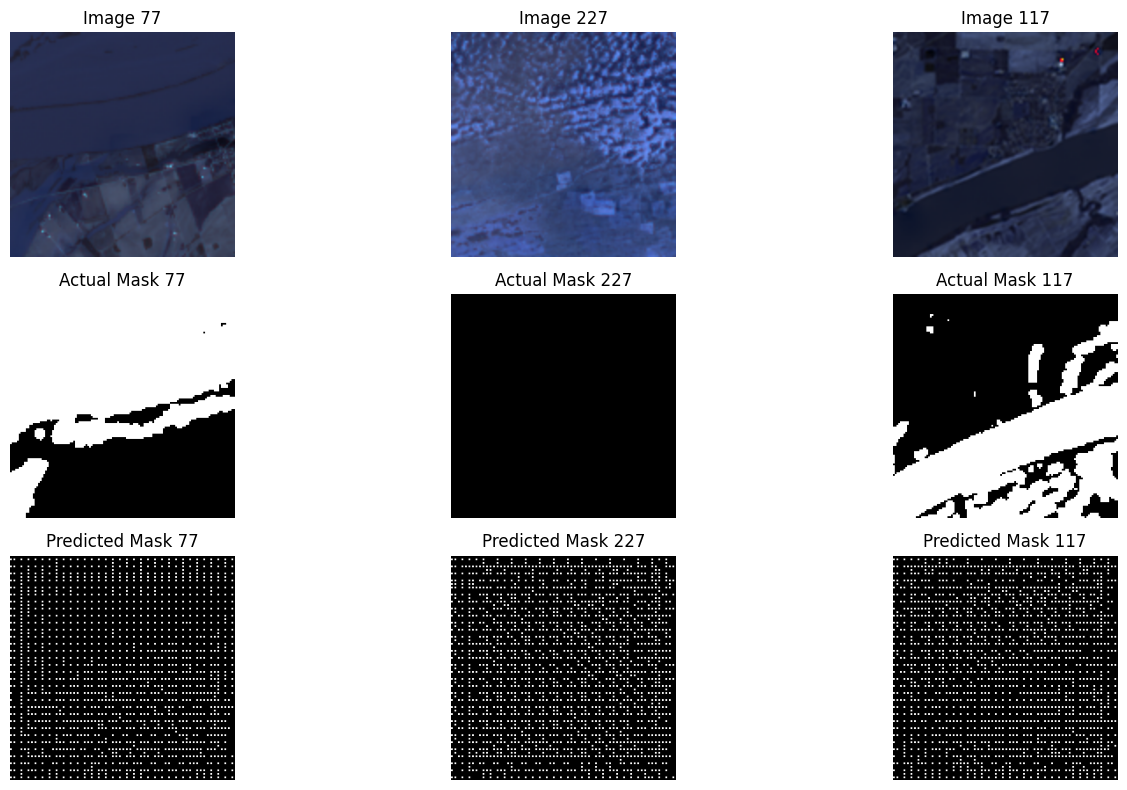

In [ ]:
# Function to preprocess image (normalize)
def preprocess_image(image):
    """Normalize the image to [0,1] range for model prediction."""
    image = image.astype(np.float32) / 255.0  # Normalize to 0-1
    return image
# Ensure matching images and labels (based on filename without extension)
image_files_dict = {os.path.splitext(f)[0]: f for f in image_files}
label_files_dict = {os.path.splitext(f)[0]: f for f in label_files}
# Find common files (ensuring correct matches)
common_keys = sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))
# Select 3 random samples from matching files
num_samples = min(3, len(common_keys))  # Avoid errors if less than 3 pairs exist
selected_keys = random.sample(common_keys, num_samples)
# Set figure size
fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))
for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])
    # Load multispectral image (12 channels)
    image = tiff.imread(image_path)
    # Convert to RGB using the first 3 channels
    image_rgb = image[:, :, :3]
    # Normalize to 8-bit (0-255) for visualization
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)
    # Preprocess image for model prediction (only 6 channels)
    image_6_channels = image[:, :, :6]  # Select only the first 6 channels
    input_image = preprocess_image(image_6_channels)  # Normalize the image
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    # Get model prediction
    prediction = best_model.predict(input_image)[0]  # Remove batch dimension
    prediction = (prediction > 0.5).astype(np.uint8)  # Threshold for binary mask
    # Load label image in grayscale
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    # Resize images for better visualization
    target_size = (256, 256)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    pred_resized = cv2.resize(prediction, target_size, interpolation=cv2.INTER_NEAREST)
    # Display the input image
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")
    # Display the ground truth mask
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Actual Mask {key}")
    axes[1, i].axis("off")
    # Display the predicted mask
    axes[2, i].imshow(pred_resized, cmap="gray")
    axes[2, i].set_title(f"Predicted Mask {key}")
    axes[2, i].axis("off")
# Adjust spacing and show the plot
plt.tight_layout()
plt.show()
